<a href="https://colab.research.google.com/github/JacksonLeb/tensorflow_learning/blob/main/08_rnn_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#introduction to NLP fundamentals in Tf

##Getting info from natural language (sequences or speech)
##NLP can also be called seq2seq problems

###Checking for GPU


In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e606db87-1c65-8445-0d8b-f80d63df48d1)


In [2]:
##Get helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-30 17:54:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-30 17:54:14 (74.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [4]:
##Get a text dataset
###Using the Kaggle Intro to NLP dataset, samples of tweets labeled hazard or not
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2022-07-30 17:54:19--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 172.253.62.128, 142.251.45.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2022-07-30 17:54:19 (90.7 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
unzip_data("nlp_getting_started.zip")

##Visualizing a text dataset

In [6]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [8]:
train_df["text"][10]

'Three people died from the heat wave so far'

In [9]:
train_df["text"][100]

'.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad'

In [10]:
#shuffle trianing df
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [11]:
#test df
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
#examples of each class
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [13]:
#total num of samples
len(train_df), len(test_df)

(7613, 3263)

In [14]:
#visualizing random samples
import random
random_index = random.randint(0, len(train_df)-5) #create random index
for row in train_df_shuffled[["text", "target"]][random_index:random_index +5 ].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}")

Target: 0 (not real disaster)
Text:
@pxnatosil @RenuncieDilma  Fatality!
Target: 0 (not real disaster)
Text:
'But right now you're only annoyed by them. If you actually hung out with them you'd see that they mean no harm.' @AudaciousSpunk
Target: 0 (not real disaster)
Text:
Drake spokes rep for the raptors.Beg to differ the other night when shots rang out at Musik wasn't a goodlook.Running in panic no fun
Target: 0 (not real disaster)
Text:
Looks like it may have been microsofts anti virus trying to update causing the meltdown
Target: 0 (not real disaster)
Text:
#Healthcare #Job in #Kodiak AK: Emergency Services Supervisor - Emergency... at Providence Health &amp; Services http://t.co/8KJ1wDAiGj #Jobs


In [15]:
#splittting data into training and validation
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=30)

In [16]:
#checking lengths of each data set
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [17]:
#check the first 10 sentences
train_sentences[:10]

array(["All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       "@DavidJordan88 @Stephanenny Except we don't know who started the riot or if it even makes sense to credit any particular individuals...",
       'Shadow boxing the apocalypse',
       "Maybe that's what happens when a tornado meets a volcano",
       '#Politics Democracy\x89Ûªs hatred for hate: \x89Û_ Dawabsha threaten to erode Israeli democracy. Homegrown terrorism ha...  http://t.co/q8n5Tn8WME',
       "@TomDean86 he's alright but Hazard/Willian ain't gonna be shifted easily.",
       '0-day bug in fully patched OS X comes under active exploit to hijack Macs http://t.co/sbGiRvQvzb',
       'Three Israeli soldiers wounded in West Bank terrorist attack via /r/worldnews http://t.co/su4ZVWADj7',
       'If it\x89Ûªs a war you came to see you will never see a waved white flag in front me.\nI can\x89Ûªt end up dead I wont be misled.',
     

In [18]:
val_sentences[:10]

array(['Blaze is my bro http://t.co/UdKeSJ01mL',
       'I was taught at school in the 1970s that piracy slavery and suicide-bombing were purely historical. No one then expected them to re-occur',
       'http://t.co/FueRk0gWui Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/Mv7GgGlmVc',
       "I'm a friggin wreck destiel sucks (read the vine description)\nhttps://t.co/MKX6Ux4OZt",
       'Dr. Bengston on #wildfire management: \x89ÛÏnumbers and size of fires areas affected and costs of fighting them all show upward trend.\x89Û\x9d #smem',
       '@ameenshaikh3 sir i just only wanted to make a point about @sureshpprabhu you made and said he is lying about bridge collapse.',
       'Wow! I just won this for free The Hobbit: Desolation of Smaug UV digital download code *GIN 9 http://t.co/MjFdCrjs8j #listia',
       'Photoset: hakogaku: ?åÊI am a kurd. i was born on a battlefield. raised on a battlefield. gunfire sirens... http://t.co/obp595W7tm',
       'Wash

## Converting text into numbers

#Tokenization and Embedding
##Tokenization: Each word/character is set to a number/one-hot encoding
##Embedding: Each word/character is set to a vector, with user-defined size, allowing for information on the relationship between tokens/words/characters. Additionally, can limit size and can be learned (treated as a weight matrix)


In [19]:
#Text Vectorization
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

#Use default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, #how many words in vocabulary (automaticaly add <OOV>)
                                    standardize="lower_and_strip_punctuation", #remove fluff,
                                    split="whitespace",
                                    ngrams=None, #create groups of n words
                                    output_mode="int", #how to map tokens to numbers
                                    output_sequence_length=None, #how long each batch of a setence should be
                                    pad_to_max_tokens=False)


In [20]:
#find average number of tokens (words) in the trianing tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [21]:
#set up text vectorization variables
max_vocab_length = 10000 # max num of words to have in vocabulary
max_length = 15 #max length of a tweet that our models sees

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, #how many words in vocabulary (automaticaly add <OOV>)
                                    standardize="lower_and_strip_punctuation", #remove fluff,
                                    split="whitespace",
                                    ngrams=None, #create groups of n words
                                    output_mode="int", #how to map tokens to numbers
                                    output_sequence_length=max_length, #how long each batch of a setence should be
                                    pad_to_max_tokens=True)

In [22]:
#adapting text_vectorizer to training data
text_vectorizer.adapt(train_sentences) #adapt to training data, very important

In [23]:
train_sentences[:10]

array(["All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       "@DavidJordan88 @Stephanenny Except we don't know who started the riot or if it even makes sense to credit any particular individuals...",
       'Shadow boxing the apocalypse',
       "Maybe that's what happens when a tornado meets a volcano",
       '#Politics Democracy\x89Ûªs hatred for hate: \x89Û_ Dawabsha threaten to erode Israeli democracy. Homegrown terrorism ha...  http://t.co/q8n5Tn8WME',
       "@TomDean86 he's alright but Hazard/Willian ain't gonna be shifted easily.",
       '0-day bug in fully patched OS X comes under active exploit to hijack Macs http://t.co/sbGiRvQvzb',
       'Three Israeli soldiers wounded in West Bank terrorist attack via /r/worldnews http://t.co/su4ZVWADj7',
       'If it\x89Ûªs a war you came to see you will never see a waved white flag in front me.\nI can\x89Ûªt end up dead I wont be misled.',
     

In [24]:
#Create sample setnces and tokenize it
sample_sentence = "A tornado destroyed my house"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  3, 595, 346,  13, 311,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [25]:
#Choose a random sentence from the triaing dataset and vectorize it
random_sentence = random.choice(train_sentences)
print(f"original sentence: {random_sentence}\n vectorized sentence: {text_vectorizer([random_sentence])}")

original sentence: Slightly doesn't help that he has Suh and Wake in practice. But think he will get there. A lot of weapons! #FinsUp 
http://t.co/i1EeUxxZ3A
 vectorized sentence: [[1998  661  159   16   60   43 4480    7  556    4 1621   30  131   60
    39]]


In [26]:
#number of unique words found in train_sentences
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Num of words: {len(words_in_vocab)}")
top_5_words, bottom_5_words

Num of words: 10000


(['', '[UNK]', 'the', 'a', 'in'],
 ['panda', 'panama', 'pampalmater', 'palmoil', 'palmer'])

### Creating an embedding using an embedding layer


In [27]:
#using tensorflow.keras.layeres.Embedding
##Parameters: input_dim, output_dim, input_length
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length)
embedding

In [28]:
#get a random sentence
random_sentence = random.choice(train_sentences)
print(f"random sentence: {random_sentence}")
print(f"embedded:")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

random sentence: #ArrestpastorNganga it so worrying 2 see how some police officers in Kenya have sunk to low to the point of collaborating with pick pockets
embedded:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00634   , -0.03411329, -0.02733816, ..., -0.00109199,
         -0.00367967, -0.0394413 ],
        [-0.00848218,  0.01149243,  0.0114172 , ..., -0.04313705,
          0.02088666, -0.04094946],
        [-0.01337736, -0.04845222,  0.03097222, ..., -0.03989774,
         -0.01485755,  0.01324748],
        ...,
        [ 0.02257364,  0.04437787, -0.04884931, ...,  0.00102862,
          0.04846447, -0.00687462],
        [ 0.02905599,  0.01677786, -0.04664249, ..., -0.01259058,
         -0.02605264,  0.02007088],
        [ 0.04488838,  0.04708029, -0.01132544, ..., -0.01845799,
          0.01498476, -0.00463766]]], dtype=float32)>

In [29]:
sample_embed[0][0], sample_embed[0][0].shape, 

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.00634   , -0.03411329, -0.02733816, -0.0009669 ,  0.03351059,
        -0.01346784,  0.03323222, -0.01625564,  0.02858922,  0.04201715,
         0.02553289, -0.04571294, -0.03280514,  0.01608136, -0.01739334,
         0.04982579, -0.0101439 ,  0.04106735, -0.01710286,  0.0390091 ,
         0.02954758,  0.02010364,  0.00813643,  0.01636772,  0.00709865,
        -0.01273628,  0.00489771,  0.03026823,  0.03133457,  0.00742309,
         0.02342864,  0.01824968,  0.0356108 , -0.0146366 ,  0.0182444 ,
         0.02948438, -0.04666114,  0.01902426, -0.04081707,  0.01490441,
        -0.00650771, -0.04615752, -0.03867546,  0.0443169 ,  0.03351157,
         0.00038517, -0.02195569,  0.03274883,  0.04365213,  0.02265698,
        -0.00661444,  0.03633923,  0.01207817, -0.03657149, -0.04663044,
         0.02837029, -0.04767438,  0.04422189, -0.0082325 , -0.04991914,
         0.00923814,  0.0083212 , -0.00327548, -0.04193168, -0.03522986,
  

##Modelling a text dataset (running series of experiments)
###1. Naive bayes with Tf-IDF encoder (BASELINE)
###2. Feed-forward neural network 
###3. LSTM
###4. GRU
###5. Bidirectiona;-LSTM
###6. 1D CNN
###7. TFHub pretrianed feature extractor
###8. TFHub pretrained with 10% of trained datam



In [30]:
###Model 0: Getting a baseline - Skleanrs multinomial naive bayes with tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), #convert words to numbers
                    ("clf", MultinomialNB()) #model the text

])

#fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [31]:
#Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)

In [32]:
baseline_score

0.8044619422572179

In [33]:
print(f"Baseline Score: {baseline_score*100:.2f}%")

Baseline Score: 80.45%


In [34]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:30]

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1])

In [35]:
### creating an evaluation function for our modeling experiements
#Accuracy, Precision, Recall and f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, preicision, recall and f1-score
  """
  #calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  
  #precision, recall and f1-score(using weighted average)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  
  model_results = {
      "accuracy": model_accuracy,
      "precision": model_precision,
      "recall": model_recall,
      "f1": model_f1
  }

  return model_results

In [36]:
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 80.4461942257218,
 'f1': 0.7993754401853582,
 'precision': 0.8113250534023555,
 'recall': 0.8044619422572179}

In [37]:
### Model 1: Feed Forward NN

# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"


In [38]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [39]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [40]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [41]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20220730-175429
Epoch 1/5
215/215 [==============================] - 8s 8ms/step - loss: 0.6134 - accuracy: 0.6885 - val_loss: 0.5170 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.4444 - accuracy: 0.8187 - val_loss: 0.4434 - val_accuracy: 0.8045
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3499 - accuracy: 0.8600 - val_loss: 0.4276 - val_accuracy: 0.8150
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2870 - accuracy: 0.8901 - val_loss: 0.4416 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2400 - accuracy: 0.9098 - val_loss: 0.4590 - val_accuracy: 0.7992


In [42]:
#check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4590 - accuracy: 0.7992


[0.45900651812553406, 0.7992125749588013]

In [43]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs

array([[5.86788952e-02],
       [6.90048218e-01],
       [9.98115182e-01],
       [1.30702764e-01],
       [9.76066828e-01],
       [6.52346462e-02],
       [8.54566321e-03],
       [1.99619561e-01],
       [9.96116638e-01],
       [9.83876646e-01],
       [3.58607173e-02],
       [2.14799508e-01],
       [9.99607146e-01],
       [7.02357963e-02],
       [4.75582629e-02],
       [5.10607898e-01],
       [9.98073936e-01],
       [2.43383393e-01],
       [6.35033906e-01],
       [4.28218901e-01],
       [1.14470840e-01],
       [3.39518368e-01],
       [9.04472709e-01],
       [5.91511488e-01],
       [3.37139815e-01],
       [9.99111474e-01],
       [2.46820286e-01],
       [3.18832286e-02],
       [9.74665880e-01],
       [9.99903083e-01],
       [9.99417901e-01],
       [1.91243663e-01],
       [4.44142103e-01],
       [4.14044932e-02],
       [7.32851923e-02],
       [9.65080619e-01],
       [9.81498696e-03],
       [4.31085914e-01],
       [4.11011696e-01],
       [5.23997955e-02],


In [44]:
model_1_pred_probs[0]

array([0.0586789], dtype=float32)

In [45]:
model_1_pred_probs.shape

(762, 1)

In [46]:
model_1_pred_probs[:10]

array([[0.0586789 ],
       [0.6900482 ],
       [0.9981152 ],
       [0.13070276],
       [0.9760668 ],
       [0.06523465],
       [0.00854566],
       [0.19961956],
       [0.99611664],
       [0.98387665]], dtype=float32)

In [47]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1

In [48]:
#Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.92125984251969,
 'f1': 0.7989121284115505,
 'precision': 0.7987486083787252,
 'recall': 0.7992125984251969}

In [49]:
baseline_results = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [50]:
words_in_vocab

['',
 '[UNK]',
 'the',
 'a',
 'in',
 'to',
 'of',
 'and',
 'i',
 'is',
 'for',
 'on',
 'you',
 'my',
 'with',
 'it',
 'that',
 'at',
 'by',
 'this',
 'from',
 'be',
 'are',
 'was',
 'have',
 'like',
 'me',
 'as',
 'up',
 'just',
 'but',
 'so',
 'im',
 'not',
 'amp',
 'your',
 'out',
 'its',
 'all',
 'will',
 'after',
 'no',
 'fire',
 'has',
 'an',
 'when',
 'if',
 'get',
 'now',
 'we',
 'about',
 'new',
 'via',
 'more',
 'or',
 'people',
 'what',
 'news',
 'one',
 'how',
 'he',
 'they',
 'over',
 'dont',
 'been',
 'who',
 'into',
 'video',
 'were',
 'do',
 'can',
 '2',
 'us',
 'disaster',
 'emergency',
 'there',
 'police',
 'than',
 'would',
 'still',
 'his',
 'some',
 'her',
 'body',
 'burning',
 'storm',
 'crash',
 'back',
 'had',
 'suicide',
 'man',
 'why',
 'know',
 'got',
 'them',
 'buildings',
 'world',
 'time',
 'off',
 'see',
 'california',
 'first',
 'day',
 'rt',
 'bomb',
 'youtube',
 'cant',
 'love',
 'nuclear',
 'going',
 'their',
 'dead',
 'two',
 'train',
 'killed',
 'go'

In [51]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [52]:
#get weight matrix of embedding layer
#numerical representations of each token in our training data, learned for 5 epochs
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [53]:
embed_weights

array([[-0.00093335, -0.05233907,  0.02591362, ..., -0.02182777,
         0.00608161,  0.00829956],
       [-0.00620219, -0.03787991, -0.02619308, ...,  0.00029334,
        -0.00116826, -0.03886334],
       [ 0.0493309 ,  0.01820524,  0.02168775, ...,  0.03159839,
        -0.00606056,  0.05337802],
       ...,
       [-0.06866074,  0.06444575, -0.06795012, ..., -0.02404651,
        -0.06006249, -0.03016897],
       [-0.05499896,  0.07174769, -0.03598017, ..., -0.08194141,
        -0.03921252, -0.05171083],
       [ 0.03398293, -0.08831825,  0.02714097, ...,  0.06196194,
         0.00611054,  0.01944149]], dtype=float32)

In [54]:
#projector tool
import io
out_v = io.open('vectors.tsv', 'w', encoding="utf-8")
out_m = io.open('metadata.tsv', 'w', encoding="utf-8")

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue

  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [55]:
#download files from colab and upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Recurrent Neural Network

##useful for sequence data - use representation of previous input to aid the representation of a later input

In [56]:
### Model 2: LSTM
###LSTM = Long Short Term Memory (one of the most popular RNN)
'''
 input(text) -> toeknize -> embed -> layers (RNNs/Dense) -> Output
'''

'\n input(text) -> toeknize -> embed -> layers (RNNs/Dense) -> Output\n'

In [57]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
#x = layers.LSTM(64, return_sequences=True)(x)
#print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [58]:
#Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [59]:
#compile
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [60]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220730-175444
Epoch 1/5
215/215 [==============================] - 6s 8ms/step - loss: 0.2334 - accuracy: 0.9183 - val_loss: 0.5401 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1567 - accuracy: 0.9438 - val_loss: 0.5593 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1273 - accuracy: 0.9549 - val_loss: 0.6590 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1043 - accuracy: 0.9615 - val_loss: 0.9083 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0857 - accuracy: 0.9667 - val_loss: 0.9631 - val_accuracy: 0.7703


In [61]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[2.7337461e-03],
       [9.4766408e-01],
       [9.9967837e-01],
       [7.5921612e-03],
       [9.9934167e-01],
       [5.0018006e-03],
       [2.6041004e-04],
       [6.0779918e-03],
       [9.9965644e-01],
       [9.9958235e-01]], dtype=float32)

In [62]:
#convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 0., 0., 0., 1., 1.], dtype=float32)>

In [63]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)

In [64]:
model_2_results

{'accuracy': 77.03412073490814,
 'f1': 0.7698916484806789,
 'precision': 0.769660000553622,
 'recall': 0.7703412073490814}

In [65]:
#Model 3: GRU
#GRU = Gated recurrent unit
##GRU is similar to LSTM, but has less parameters

In [66]:
from tensorflow.keras import layers

model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")


inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

'''
# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")
'''


'\n# Build an RNN using the GRU cell\ninputs = layers.Input(shape=(1,), dtype="string")\nx = text_vectorizer(inputs)\nx = model_3_embedding(x)\n# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True\nx = layers.GRU(64)(x) \n# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell\noutputs = layers.Dense(1, activation="sigmoid")(x)\nmodel_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")\n'

In [67]:
#compile
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [68]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [69]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20220730-175457
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.1563 - accuracy: 0.9380 - val_loss: 0.8505 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0798 - accuracy: 0.9696 - val_loss: 0.8466 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0697 - accuracy: 0.9712 - val_loss: 0.8684 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0663 - accuracy: 0.9723 - val_loss: 1.1653 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0553 - accuracy: 0.9753 - val_loss: 1.1224 - val_accuracy: 0.7638


In [70]:
model_3_preds = tf.squeeze(tf.round(model_3.predict(val_sentences)))
model_3_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1

In [71]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)

In [72]:
model_3_results

{'accuracy': 76.37795275590551,
 'f1': 0.7635827883174681,
 'precision': 0.7634285816082944,
 'recall': 0.7637795275590551}

In [73]:
#Model 4: Bidirectional RNN
##goes left to right and right to left

In [74]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4")

In [75]:
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-tra

In [76]:
#compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [77]:
# Fit model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "Bidrectional")])

Saving TensorBoard log files to: model_logs/Bidrectional/20220730-175506
Epoch 1/5
215/215 [==============================] - 5s 11ms/step - loss: 0.1034 - accuracy: 0.9699 - val_loss: 0.9955 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0522 - accuracy: 0.9762 - val_loss: 1.1774 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0443 - accuracy: 0.9783 - val_loss: 1.3421 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0422 - accuracy: 0.9799 - val_loss: 1.5236 - val_accuracy: 0.7507
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0406 - accuracy: 0.9794 - val_loss: 1.4545 - val_accuracy: 0.7415


In [78]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs

array([[3.30881856e-04],
       [9.86408591e-01],
       [9.99985218e-01],
       [1.10942172e-03],
       [9.99937534e-01],
       [8.81536007e-02],
       [1.41749706e-05],
       [6.58327132e-04],
       [9.99829292e-01],
       [9.99978781e-01],
       [3.50831222e-04],
       [8.10304715e-04],
       [9.99993920e-01],
       [1.95194662e-04],
       [4.37968520e-05],
       [8.47523749e-01],
       [9.99988914e-01],
       [7.10556225e-04],
       [9.90121603e-01],
       [9.63982880e-01],
       [1.45598883e-02],
       [7.22153159e-03],
       [9.99546230e-01],
       [6.15829170e-01],
       [1.26990164e-02],
       [9.99989867e-01],
       [8.98571452e-04],
       [1.39907832e-04],
       [9.99888659e-01],
       [9.99987125e-01],
       [9.99985576e-01],
       [1.33514707e-03],
       [9.87563670e-01],
       [7.59155446e-05],
       [1.14206647e-04],
       [9.99973536e-01],
       [2.11905826e-05],
       [9.61932659e-01],
       [3.12310690e-03],
       [1.49409389e-04],


In [79]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))

In [80]:
model_4_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 1., 1.], dtype=float32)>

In [81]:
#calc the results of biredcational model
model_4_results = calculate_results(val_labels, model_4_preds)

In [82]:
model_4_results

{'accuracy': 74.1469816272966,
 'f1': 0.7425295159659813,
 'precision': 0.7454480879390357,
 'recall': 0.7414698162729659}

#Convolution Neural Networks for Text (and other sequences)

#Model 5: Conv1D NN

In [83]:
#Test out our embedding layer, Conv1d layer and pooling layer
embedding_test = embedding(text_vectorizer(["This is a test sentence"]))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding="valid")

conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # Get the most important feature
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [84]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 5.9401777e-02, -8.0554873e-02, -2.0926047e-02, ...,
          2.5527958e-02,  7.0057027e-02, -2.0466179e-02],
        [ 4.0905189e-02,  2.0496104e-02,  4.4687774e-02, ...,
         -3.1735960e-02, -6.5073255e-03,  3.6059108e-02],
        [-4.2772599e-02,  3.8686223e-02,  1.4977301e-02, ...,
          2.6833275e-02,  4.0736418e-02,  4.7129984e-03],
        ...,
        [ 2.1100075e-03, -4.6237968e-02,  9.5080882e-03, ...,
          9.0071076e-04,  6.1466548e-05,  5.4679578e-03],
        [ 2.1100075e-03, -4.6237968e-02,  9.5080882e-03, ...,
          9.0071076e-04,  6.1466548e-05,  5.4679578e-03],
        [ 2.1100075e-03, -4.6237968e-02,  9.5080882e-03, ...,
          9.0071076e-04,  6.1466548e-05,  5.4679578e-03]]], dtype=float32)>

In [85]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.02046588, 0.        , 0.01510248, 0.01134766, 0.00376934,
         0.05325548, 0.05843903, 0.00196538, 0.        , 0.        ,
         0.07833953, 0.00752475, 0.10070987, 0.        , 0.        ,
         0.        , 0.05888323, 0.04493806, 0.05834231, 0.        ,
         0.        , 0.        , 0.01172077, 0.03658486, 0.08674968,
         0.02137731, 0.08860622, 0.01987527, 0.        , 0.00761625,
         0.        , 0.        ],
        [0.02076238, 0.00470237, 0.        , 0.03293324, 0.        ,
         0.07943621, 0.        , 0.02455911, 0.04292443, 0.        ,
         0.05956221, 0.        , 0.        , 0.01409604, 0.        ,
         0.        , 0.00942169, 0.        , 0.        , 0.        ,
         0.        , 0.0569893 , 0.02556253, 0.        , 0.05271862,
         0.        , 0.01508843, 0.0175335 , 0.        , 0.05182746,
         0.        , 0.        ],
        [0.        , 0.01775323, 0.        , 0.    

In [86]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.02076238, 0.11840934, 0.01971008, 0.03293324, 0.00376934,
        0.07943621, 0.05843903, 0.02455911, 0.09444112, 0.01621869,
        0.07833953, 0.03969269, 0.10070987, 0.0949917 , 0.02950467,
        0.03163496, 0.05888323, 0.04493806, 0.05834231, 0.        ,
        0.01029116, 0.06805236, 0.05408438, 0.03805972, 0.08674968,
        0.02137731, 0.08860622, 0.01987527, 0.        , 0.05182746,
        0.03389873, 0.02590691]], dtype=float32)>

In [87]:
#Model 5: 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)


outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5")

In [88]:
model_5.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [89]:
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)                 65  

In [90]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20220730-175526
Epoch 1/5
215/215 [==============================] - 3s 6ms/step - loss: 0.1242 - accuracy: 0.9584 - val_loss: 0.9360 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0758 - accuracy: 0.9708 - val_loss: 1.0815 - val_accuracy: 0.7454
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0630 - accuracy: 0.9731 - val_loss: 1.1616 - val_accuracy: 0.7493
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0564 - accuracy: 0.9771 - val_loss: 1.2252 - val_accuracy: 0.7428
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0534 - accuracy: 0.9768 - val_loss: 1.2526 - val_accuracy: 0.7454


In [91]:
model_5_pred_probs = model_5.predict(val_sentences)

In [92]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))

In [93]:
model_5_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1

In [94]:
model_5_results = calculate_results(val_labels, model_5_preds)

In [95]:
model_5_results

{'accuracy': 74.54068241469817,
 'f1': 0.7453026865121976,
 'precision': 0.7452088992828466,
 'recall': 0.7454068241469817}

#Universal Sentence Encoder transfer learning

In [96]:
#model 5
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,"When you call a USE on a sentence, it turn sit into numbers"])


In [97]:
sample_sentence

'A tornado destroyed my house'

In [98]:
embed_samples[0][:50]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([-0.01050084, -0.00229794, -0.05725909, -0.04777098,  0.04511795,
        0.02202453,  0.02400334,  0.0667739 , -0.00083695,  0.05448426,
        0.05745116, -0.04347977, -0.00139513,  0.01398681,  0.046919  ,
       -0.01260869, -0.06758504, -0.02162268, -0.00623832, -0.00575831,
        0.01941228, -0.00105522,  0.0304017 ,  0.06340312, -0.02500383,
       -0.07751907,  0.04895177, -0.04103375,  0.00698542, -0.0394792 ,
        0.03514631,  0.03659685, -0.05294777,  0.02191273, -0.02828331,
       -0.01387694,  0.05540748,  0.01839826, -0.02460213, -0.03052922,
        0.04902494, -0.0124156 , -0.01220245, -0.05936461, -0.08365225,
       -0.01479258, -0.0334257 , -0.00039739,  0.01519083, -0.01560132],
      dtype=float32)>

In [99]:
embed_samples[0].shape

TensorShape([512])

In [100]:
#Create keras layer using pretrained embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [101]:
#model 6
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="sigmoid"),
  layers.Dense(1, activation="sigmoid")
], name='model_6')

model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [102]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Transfer_Learning_THUB")])

Saving TensorBoard log files to: model_logs/Transfer_Learning_THUB/20220730-175552
Epoch 1/5
215/215 [==============================] - 7s 16ms/step - loss: 0.5953 - accuracy: 0.7233 - val_loss: 0.4997 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4773 - accuracy: 0.8028 - val_loss: 0.4324 - val_accuracy: 0.8202
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4416 - accuracy: 0.8065 - val_loss: 0.4074 - val_accuracy: 0.8281
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4275 - accuracy: 0.8119 - val_loss: 0.3962 - val_accuracy: 0.8360
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4197 - accuracy: 0.8173 - val_loss: 0.3906 - val_accuracy: 0.8281


In [103]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

In [104]:
model_6_results = calculate_results(val_labels,
                                    model_6_preds)

In [105]:
model_6_results

{'accuracy': 82.80839895013123,
 'f1': 0.8279775568573017,
 'precision': 0.8278971804091912,
 'recall': 0.8280839895013123}

## Model 7: TF HUB pretraned USE with 10%

In [106]:
#Create a subsets of 10% of the training data
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()

In [107]:
len(train_sentences_10_percent)

761

In [108]:
train_sentences_10_percent[:10]

['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
 'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
 'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
 '@camilacabello97 Internally and externally screaming',
 'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov',
 'Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8',
 'How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd',
 "Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over southern China by S\x89Û_ http://t.co/JDVSGVhlIs",
 '\x89Û

In [109]:
train_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [110]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [111]:
model_7_history = model_6.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Transfer_Learning_THUB_10_percent")])

Saving TensorBoard log files to: model_logs/Transfer_Learning_THUB_10_percent/20220730-175610
Epoch 1/5
24/24 [==============================] - 1s 27ms/step - loss: 0.4305 - accuracy: 0.8160 - val_loss: 0.3906 - val_accuracy: 0.8294
Epoch 2/5
24/24 [==============================] - 0s 20ms/step - loss: 0.4263 - accuracy: 0.8160 - val_loss: 0.3902 - val_accuracy: 0.8281
Epoch 3/5
24/24 [==============================] - 0s 21ms/step - loss: 0.4207 - accuracy: 0.8173 - val_loss: 0.3913 - val_accuracy: 0.8307
Epoch 4/5
24/24 [==============================] - 1s 24ms/step - loss: 0.4155 - accuracy: 0.8213 - val_loss: 0.3904 - val_accuracy: 0.8346
Epoch 5/5
24/24 [==============================] - 1s 24ms/step - loss: 0.4096 - accuracy: 0.8226 - val_loss: 0.3902 - val_accuracy: 0.8360


In [112]:
model_7 = tf.keras.models.clone_model(model_6)
model_7.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [113]:
#Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [114]:
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Transfer_Learning_THUB_10_percent")])

Saving TensorBoard log files to: model_logs/Transfer_Learning_THUB_10_percent/20220730-175617
Epoch 1/5
24/24 [==============================] - 3s 53ms/step - loss: 0.6803 - accuracy: 0.5545 - val_loss: 0.6601 - val_accuracy: 0.6457
Epoch 2/5
24/24 [==============================] - 1s 21ms/step - loss: 0.6492 - accuracy: 0.6689 - val_loss: 0.6345 - val_accuracy: 0.7651
Epoch 3/5
24/24 [==============================] - 1s 24ms/step - loss: 0.6246 - accuracy: 0.7385 - val_loss: 0.6120 - val_accuracy: 0.7835
Epoch 4/5
24/24 [==============================] - 0s 20ms/step - loss: 0.5993 - accuracy: 0.8068 - val_loss: 0.5903 - val_accuracy: 0.7953
Epoch 5/5
24/24 [==============================] - 0s 20ms/step - loss: 0.5766 - accuracy: 0.8055 - val_loss: 0.5697 - val_accuracy: 0.7953


In [115]:
#Make predictions on model trained on 10 percent
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1

In [116]:
model_7_results = calculate_results(val_labels, model_7_preds)

In [117]:
model_7_results

{'accuracy': 79.52755905511812,
 'f1': 0.7922439946673488,
 'precision': 0.7964327373252089,
 'recall': 0.7952755905511811}

In [118]:
#Making better dataset split with no leakage
train_10_percent_split = int(0.1 * len(train_sentences))
train_10_percent_split

685

In [119]:
train_10_percent = train_sentences[:train_10_percnet_split]

NameError: ignored

In [ ]:
train_10_percent

In [120]:
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
len(train_labels_10_percent)

In [122]:
train_labels_10_percent

array([1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,

In [123]:
model_7_results = calculate_results(val_labels, model_7_preds)

In [124]:
#Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


##Comparing all of our models


In [125]:
#Combine model results into a DataFrame
all_model_results = pd.DataFrame({"model_1": model_1_results,
                                  "model_2": model_2_results,
                                  "model_3": model_3_results,
                                  "model_4": model_4_results,
                                  "model_5": model_5_results,
                                  "model_6": model_6_results,
                                  "model_7": model_7_results,})
all_model_results
all_model_results = all_model_results.transpose()

In [126]:
# Reduce accuracy to same scale
all_model_results["accuracy"] = all_model_results["accuracy"] / 100

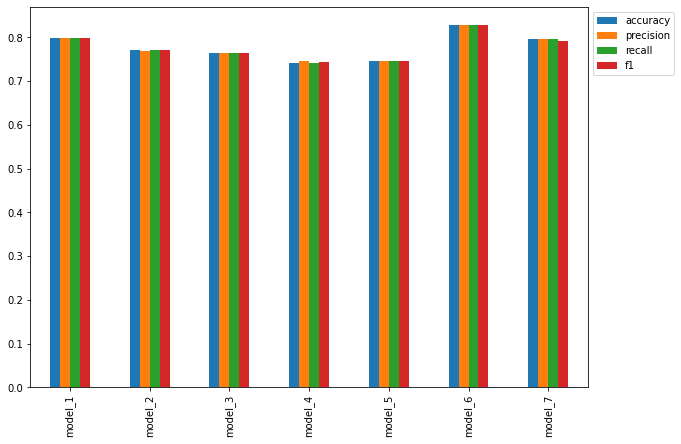

In [127]:
#PLot and compare all of the model reuslts
all_model_results.plot(kind="bar",
                       figsize=(10, 7)).legend(bbox_to_anchor=(1.0,1.0))

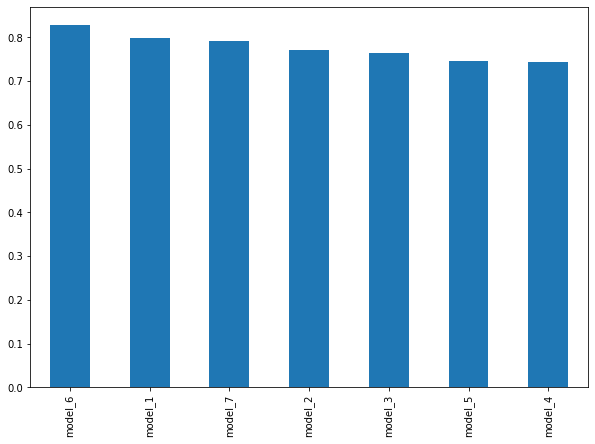

In [128]:
#Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

In [129]:
# View Tensorboard logs of transfer learning modelling experiemnts
#Upload tensorflow dev records
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling Experiments" \
  --description "Comparing multiple types of model on Hazard Tweets dataset" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) no


In [130]:
#Saving and loading a model
model_6.save("model_6.h5")

In [131]:
#load the model with custome hub layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [132]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 21ms/step - loss: 0.3902 - accuracy: 0.8360


[0.3901631534099579, 0.8359580039978027]

In [133]:
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [135]:
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [136]:
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 17ms/step - loss: 0.3902 - accuracy: 0.8360


[0.3901631534099579, 0.8359580039978027]

#Finding most wrong examples

In [137]:
#downloaded pretrianed moel
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2022-07-30 18:16:35--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 172.253.62.128, 142.251.45.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  63.4MB/s    in 12s     

2022-07-30 18:16:47 (76.7 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.inde

In [139]:
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.3369 - accuracy: 0.8583


[0.3369034230709076, 0.8582677245140076]

In [140]:
model_6_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pred_probs))

In [141]:
model_6_pretrained_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1

In [143]:
#Create dataframe with validation sentecnes and best performing model prediciton labels and probs
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df

,text,target,pred,pred_prob
0,Blaze is my bro http://t.co/UdKeSJ01mL,0,0.0,0.089644
1,I was taught at school in the 1970s that pirac...,1,0.0,0.426126
2,http://t.co/FueRk0gWui Twelve feared killed in...,1,1.0,0.992623
3,I'm a friggin wreck destiel sucks (read the vi...,0,0.0,0.026283
4,Dr. Bengston on #wildfire management: ÛÏnumbe...,1,1.0,0.865555
...,...,...,...,...
757,Usama bin Ladins family dead in airplane crash...,1,1.0,0.896717
758,@OfficialTJonez Your 'Lost For Words' made me ...,0,0.0,0.027396
759,This from The City of Calgary - \n\nCity of Ca...,1,1.0,0.790174
760,Experts in France begin examining airplane deb...,1,1.0,0.949035


In [146]:
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong

,text,target,pred,pred_prob
556,@adorableappple No reported flooding po in the...,0,1.0,0.970023
179,Teen Disaster Preparedness Event in Van Nuys A...,0,1.0,0.948890
142,Two Jewish Terrorists Charged In Historic-Chur...,0,1.0,0.918810
740,Large rain drops falling in Rock Hill off Ande...,0,1.0,0.901049
278,One thing for sure-God has promised Israel wil...,0,1.0,0.878904
...,...,...,...,...
576,Until my death I'll forever rep the Jets.,1,0.0,0.106549
748,Love living on my own. I can blaze inside my a...,1,0.0,0.103954
394,Rand Paul's Debate Strategy 'demolish Some oth...,1,0.0,0.098877
738,Jack Wilshere has poor injury recordand his of...,1,0.0,0.097724


In [148]:
#Check false positives (pred 1, actual: 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Pred_Prob; {pred_prob}")
  print(f"text: {text}")
  print(f".   ")

Target: 0, Pred: 1.0, Pred_Prob; 0.9700231552124023
text: @adorableappple No reported flooding po in the area. Ten-4. #mmda
.   
Target: 0, Pred: 1.0, Pred_Prob; 0.9488900303840637
text: Teen Disaster Preparedness Event in Van Nuys August 11 @ 5:30pm http://t.co/fXUX987vZx via @VanNuysCouncil
.   
Target: 0, Pred: 1.0, Pred_Prob; 0.9188095331192017
text: Two Jewish Terrorists Charged In Historic-Church Arson | The Ugly Truth http://t.co/iEksNFSbY7 http://t.co/VWCf3slkrW
.   
Target: 0, Pred: 1.0, Pred_Prob; 0.9010494351387024
text: Large rain drops falling in Rock Hill off Anderson Road. #rain #scwx #drought
.   
Target: 0, Pred: 1.0, Pred_Prob; 0.8789042830467224
text: One thing for sure-God has promised Israel will not be annihilated. But...the horror of Iran w/nukes. https://t.co/xn09Mx6sxy
.   
Target: 0, Pred: 1.0, Pred_Prob; 0.8490898013114929
text: @StephanieMarija 'light rain' was the forecast I based my dressing on. Light. Rain. Not incessant deluge!
.   
Target: 0, Pred: 1.0,

In [149]:
#Check false negatives (pred 1, actual: 0)
for row in most_wrong[::-10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Pred_Prob; {pred_prob}")
  print(f"text: {text}")
  print(f".   ")

Target: 1, Pred: 0.0, Pred_Prob; 0.03894943371415138
text: Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP
.   
Target: 1, Pred: 0.0, Pred_Prob; 0.14120042324066162
text: Aquarium Ornament Wreck Sailing Boat Sunk Ship Destroyer Fish Tank Cave Decor - Full read Û_ http://t.co/nosA8JJjiN http://t.co/WUKvdavUJu
.   
Target: 1, Pred: 0.0, Pred_Prob; 0.22915491461753845
text: @ameenshaikh3 sir i just only wanted to make a point about @sureshpprabhu you made and said he is lying about bridge collapse.
.   
Target: 1, Pred: 0.0, Pred_Prob; 0.2790153920650482
text: @godsfirstson1 and she wrapped his coat around herself. It practically engulfed her.
.   
Target: 1, Pred: 0.0, Pred_Prob; 0.327956885099411
text: I hope the only time I end up on TV is when I'm being arrested for lighting buildings on fire.
.   
Target: 1, Pred: 0.0, Pred_Prob; 0.37122276425361633
text: Oops: Bounty hunters try to raid Phoenix 

#Making predictions on the test_datset


In [150]:
#making predictions and visualizing
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"pred; {int(pred)}, prob: {pred_prob}")
  print(f"Text: {test_sample}")

pred; 0, prob: 0.090957872569561
Text: I added some dumb ideas to beat the #summer heat cheaply
 http://t.co/jatxpAFvA9 @brokelyn #brokelynati
pred; 1, prob: 0.8373509645462036
Text: #maritime The sand carrier Shinto Maru and chemical tanker Hoshin Maru collided on 7 nautical miles off Honshu... http://t.co/2bnfoAGpzD
pred; 0, prob: 0.29987403750419617
Text: If Oikawa was in Karasuno I guess I'd just collapse from such an overwhelming happiness.
pred; 1, prob: 0.9687044024467468
Text: Pakistani Terrorist Was Captured By Villagers He Took Hostage - NDTV http://t.co/C5X10JAkGE
pred; 0, prob: 0.11020726710557938
Text: @Stretcher @Grazed @witter @Rexyy @Towel thanks aiden
pred; 0, prob: 0.2093210518360138
Text: 320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/THyzOMVWU0 | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/83jOO0xk29
pred; 1, prob: 0.6758798360824585
Text: FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/L04Q4DKvue http:

#Speed/Score tradeoff

In [151]:
import time

def pred_timer(model, samples):
  
  start_time = time.perf_counter()
  model.predict(samples)

  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_prediction = total_time / len(samples)

  return total_time, time_per_prediction


In [152]:
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6_pretrained, val_sentences)

In [153]:
model_6_total_pred_time

0.527659309000228

In [154]:
model_6_time_per_pred

0.000692466284777202

In [155]:
model_6_pretrained_results = calculate_results(val_labels, model_6_pretraind_preds)

NameError: ignored